<a href="https://colab.research.google.com/github/MattiaSelva00/SP500_ML/blob/main/GARCH(1%2C1)_ML_%7C_SPX_model_tesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import the library
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import lazypredict
import datetime as dt
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from lazypredict.Supervised import LazyRegressor

In [2]:
#Setting Plots
plt.rcParams.update({
    'font.size': 18,          # dimensione font generale
    'axes.titlesize': 20,     # titolo del grafico
    'axes.labelsize': 18,     # etichette assi
    'xtick.labelsize': 16,    # numeri asse x
    'ytick.labelsize': 16,    # numeri asse y
    'legend.fontsize': 16     # legenda
})

In [3]:
#Choosing the ticker
ticker = yf.Ticker("^GSPC")
#Download Historical data from 1 Jan '90 to today
SPX_data = ticker.history(period="max")
#Take the last n year
SPX_trim = SPX_data.last("20Y")

In [4]:
SPX_trim.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,1418.03,1429.42,1407.86,1416.60,3429160000,0.00,0.00
2007-01-04 00:00:00-05:00,1416.60,1421.84,1408.43,1418.34,3004460000,0.00,0.00
2007-01-05 00:00:00-05:00,1418.34,1418.34,1405.75,1409.71,2919400000,0.00,0.00
2007-01-08 00:00:00-05:00,1409.26,1414.98,1403.97,1412.84,2763340000,0.00,0.00
2007-01-09 00:00:00-05:00,1412.84,1415.61,1405.42,1412.11,3038380000,0.00,0.00


In [5]:
#Taking just the closing prices
SPX_trim_Close = SPX_trim.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis = 1) #axis = 1, for column

In [6]:
SPX_trim_Close.head()

,Close
Date,
2007-01-03 00:00:00-05:00,1416.60
2007-01-04 00:00:00-05:00,1418.34
2007-01-05 00:00:00-05:00,1409.71
2007-01-08 00:00:00-05:00,1412.84
2007-01-09 00:00:00-05:00,1412.11


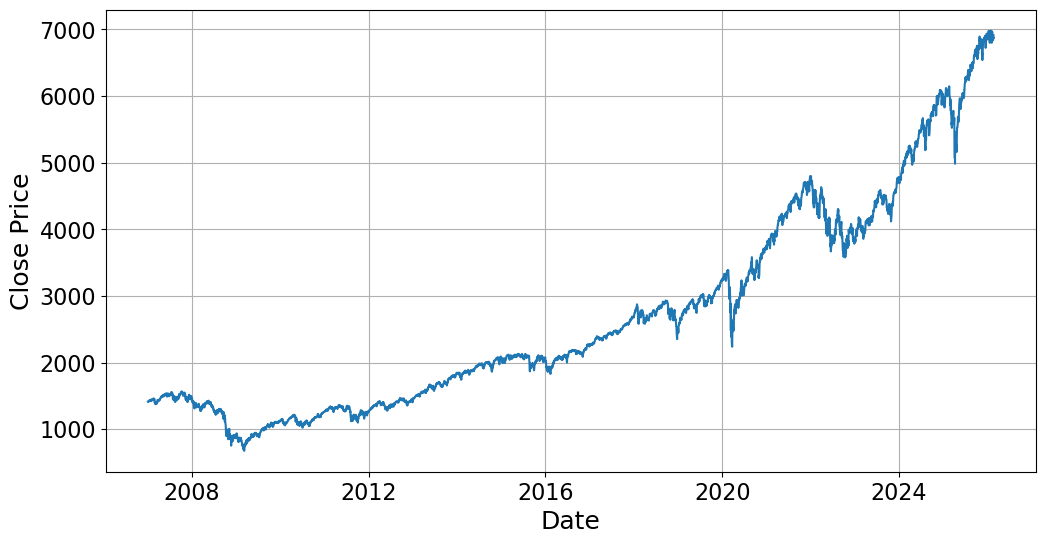

In [7]:
#Plotting the data in levels
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid()
plt.plot(SPX_trim_Close)

plt.show()

In [8]:
result = adfuller(SPX_trim_Close)
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = 2.111, p-value = 0.999


In [9]:
#Create the log of the serie
lnSPX = np.log(SPX_trim_Close)

print(lnSPX.head)

<bound method NDFrame.head of                            Close
Date                            
2007-01-03 00:00:00-05:00   7.26
2007-01-04 00:00:00-05:00   7.26
2007-01-05 00:00:00-05:00   7.25
2007-01-08 00:00:00-05:00   7.25
2007-01-09 00:00:00-05:00   7.25
...                          ...
2026-02-13 00:00:00-05:00   8.83
2026-02-17 00:00:00-05:00   8.83
2026-02-18 00:00:00-05:00   8.84
2026-02-19 00:00:00-05:00   8.83
2026-02-20 00:00:00-05:00   8.84

[4814 rows x 1 columns]>


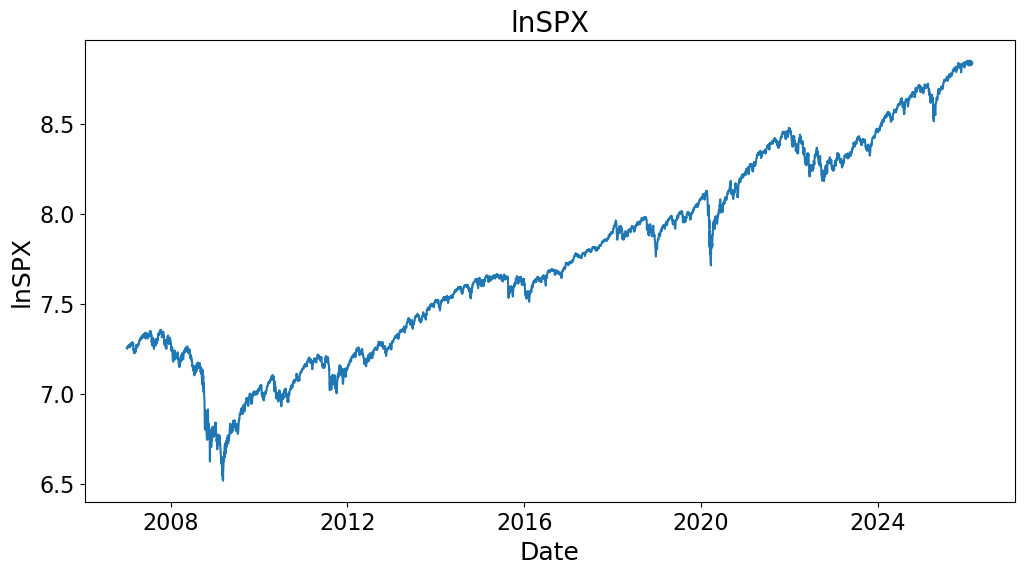

In [10]:
#Plotting the log of the serie
plt.figure(figsize=(12,6))
plt.plot(lnSPX)
plt.title('lnSPX')
plt.xlabel('Date')
plt.ylabel('lnSPX')

plt.show()

In [11]:
#Taking the first difference of the logarithm
dlnSPX = lnSPX.diff()
print(dlnSPX.head)


<bound method NDFrame.head of                            Close
Date                            
2007-01-03 00:00:00-05:00    NaN
2007-01-04 00:00:00-05:00   0.00
2007-01-05 00:00:00-05:00  -0.01
2007-01-08 00:00:00-05:00   0.00
2007-01-09 00:00:00-05:00  -0.00
...                          ...
2026-02-13 00:00:00-05:00   0.00
2026-02-17 00:00:00-05:00   0.00
2026-02-18 00:00:00-05:00   0.01
2026-02-19 00:00:00-05:00  -0.00
2026-02-20 00:00:00-05:00   0.01

[4814 rows x 1 columns]>


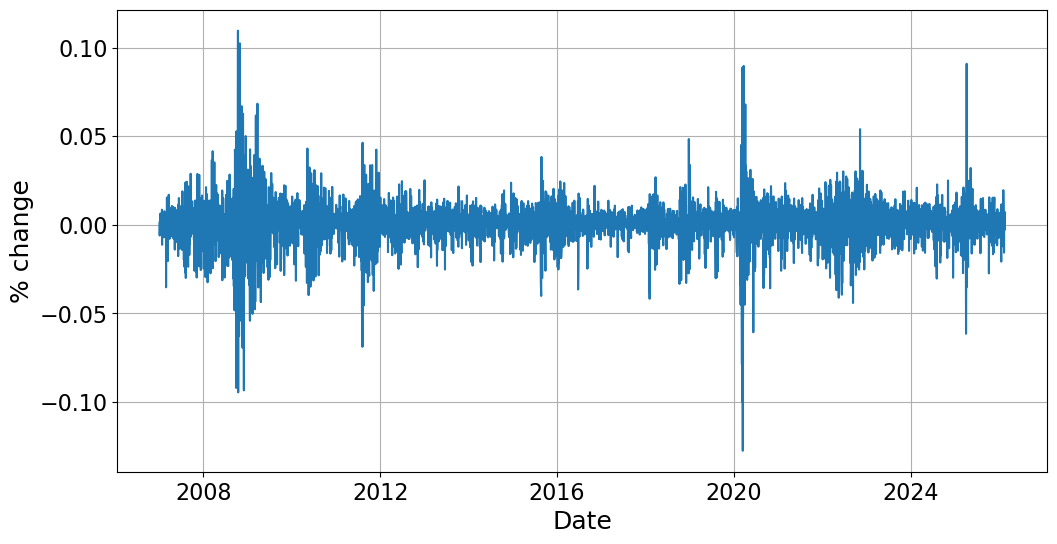

In [12]:
#Plotting dlnSPX
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('% change')
plt.grid()
plt.plot(dlnSPX)

plt.show()

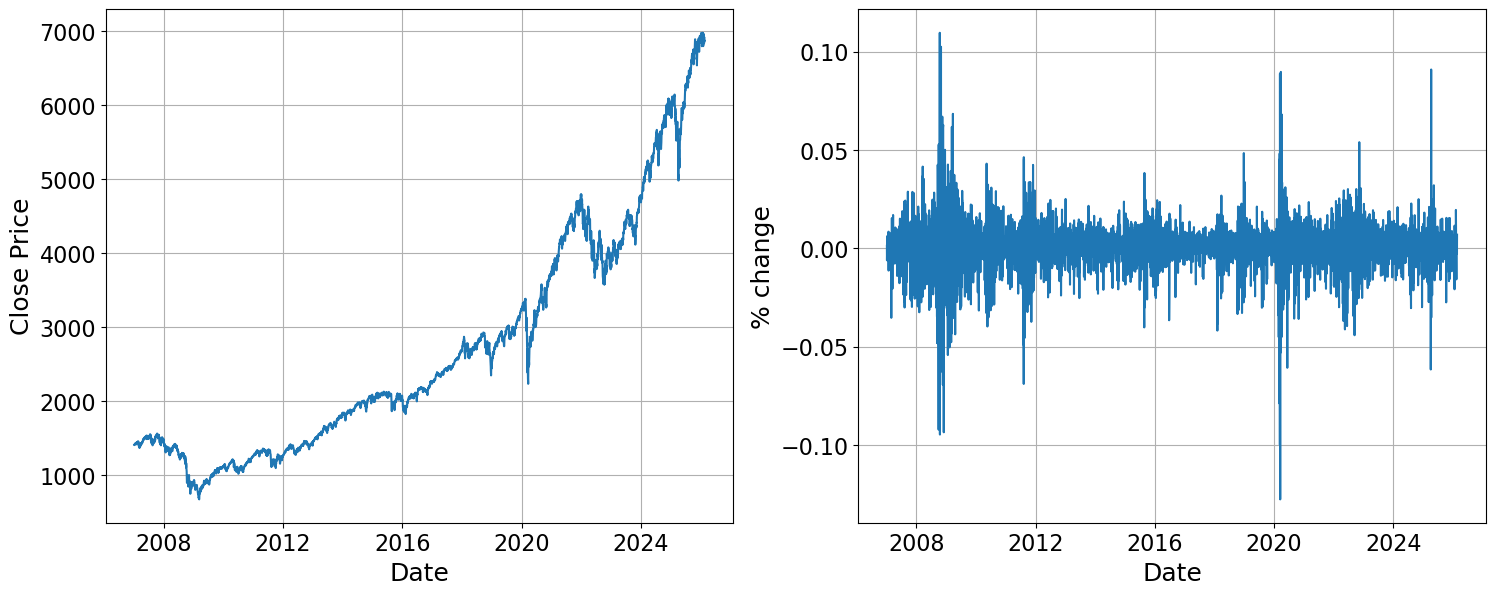

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(SPX_trim_Close)
axs[1].plot(dlnSPX)

plt.tight_layout()
axs[1].set_xlabel('Date')
axs[1].set_ylabel('% change')
axs[1].grid(True)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close Price')
axs[0].grid(True)
plt.subplots_adjust(wspace=0.2)
plt.show()

In [14]:
## REMARK FOR ADF TEST
  #   result[0]   ADF test statistic
  #   result[1]   p-value
  #   result[2]   number of lags used
  #   result[3]   number of observations used for the ADF regression and calculation of critical values
  #   result[4]   dictionary of critical values (1%, 5%, 10%)
  #   result[5]   (optional) the maximized information criterion if autolag is used

## H0 : the serie has a unit root (not stationary)
## H1 : the serie is stationary

In [15]:
#Test for stationarity in dlnSPX
result = adfuller(dlnSPX.dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -15.606800217619112
p-value: 1.800465373359837e-28


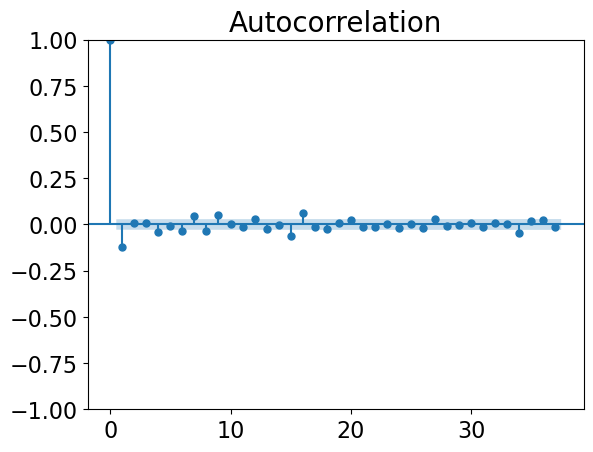

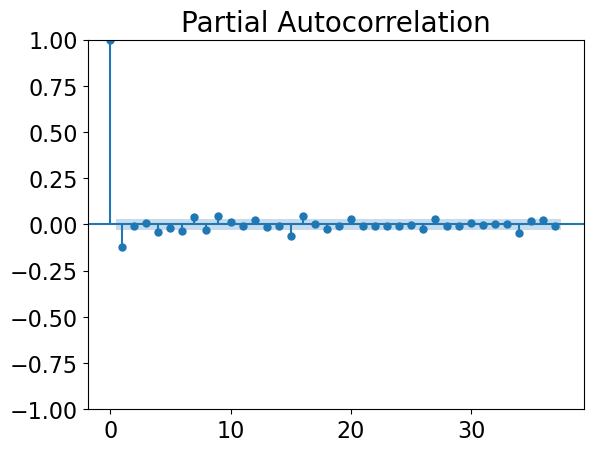

In [16]:
#Plotting AutoCorrelation function & Partial AutoCorrelation function
plot_acf(dlnSPX.dropna())
plot_pacf(dlnSPX.dropna())

plt.show()

In [17]:
##Try to fit an ARIMA
#AR(1) dlnSPX = β0 + β1*dnlnSPXt-1 + Ut
#ARMA(1,1) dlnSPX = β0 + β1*dnlnSPXt-1 + β2Ut-1 + Ut
model_ARIMA = ARIMA(dlnSPX.dropna(), order=(1, 0, 1))
model_ARIMA_fit = model_ARIMA.fit()

print(model_ARIMA_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4813
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14295.194
Date:                Mon, 23 Feb 2026   AIC                         -28582.388
Time:                        14:48:38   BIC                         -28556.472
Sample:                             0   HQIC                        -28573.287
                               - 4813                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.935      0.053   -4.29e-06       0.001
ar.L1         -0.0810      0.046     -1.776      0.076      -0.170       0.008
ma.L1         -0.0422      0.047     -0.896      0.3

In [18]:
# ====== Implementing the GARCH(1,1) ====== #

In [19]:
# GARCH(1,1) mean zero e t-Student distribution, mean "Constant" "AR" se vuoi una parte autoregressiva, dist "normal" oppure "t"
GARCH = arch_model(100 * dlnSPX.dropna(), mean="AR", lags=0, vol="GARCH", p=1, q=1, dist="t")

fit_GARCH = GARCH.fit(disp="off")   # niente spam di output durante l’ottimizzazione

print(fit_GARCH.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6428.10
Distribution:      Standardized Student's t   AIC:                           12866.2
Method:                  Maximum Likelihood   BIC:                           12898.6
                                              No. Observations:                 4813
Date:                      Mon, Feb 23 2026   Df Residuals:                     4812
Time:                              14:48:38   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const     

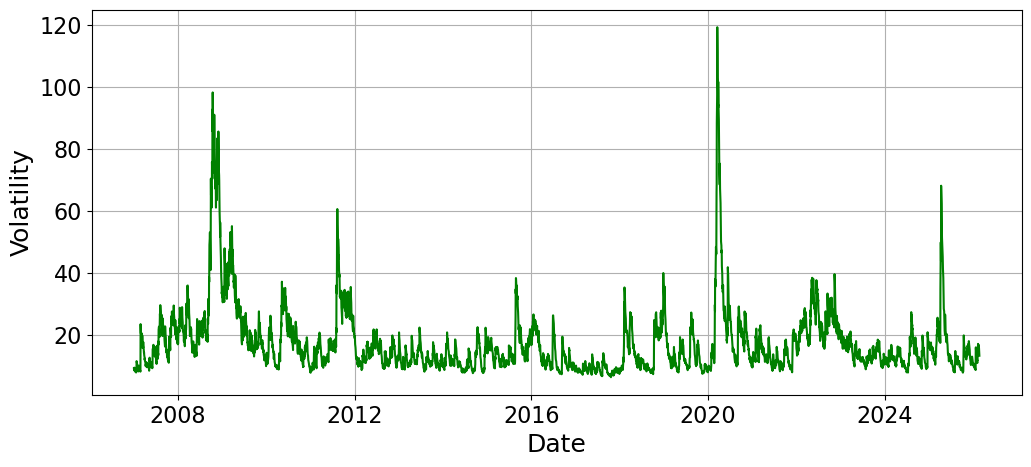

In [20]:
#GARCH works on the variance I need Volatility
vol = fit_GARCH.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(vol*(252**0.5), color='green', label='Volatilità GARCH')
plt.grid()
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

In [21]:
hv_xday = 100 * dlnSPX.rolling(21).std()*(252**0.5)

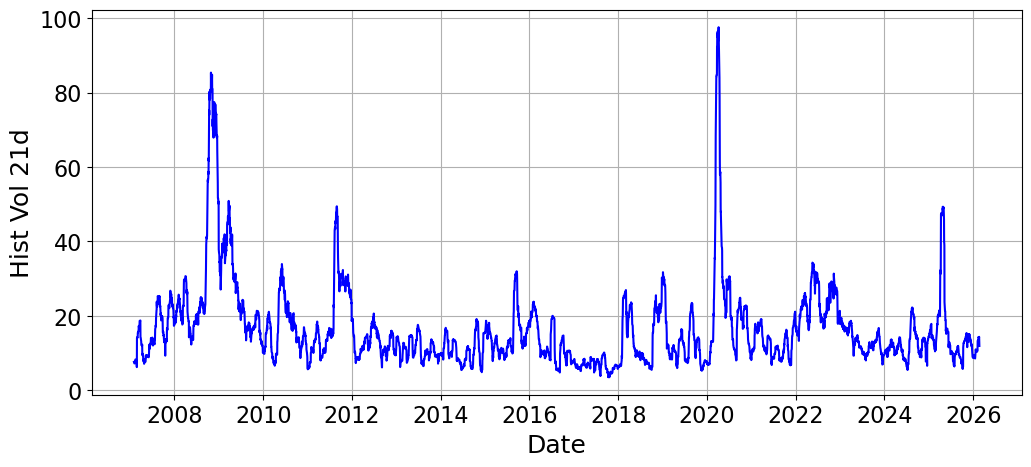

In [22]:
plt.figure(figsize=(12,5))
plt.plot(hv_xday, color='blue')
plt.grid()
plt.xlabel("Date")
plt.ylabel("Hist Vol 21d")
plt.show()

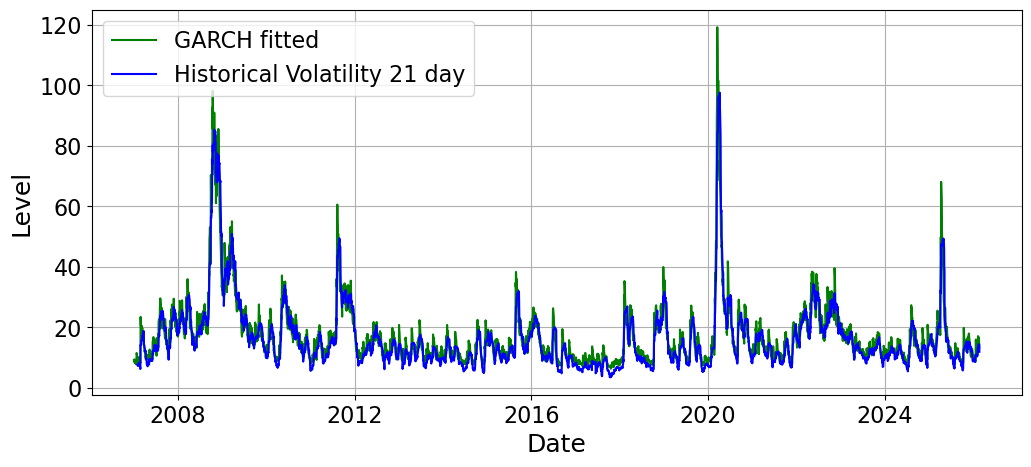

In [23]:
plt.figure(figsize=(12,5))
plt.plot(vol*(252**0.5), color='green', label='GARCH fitted')
plt.plot(hv_xday, color='blue', label='Historical Volatility 21 day')
plt.xlabel('Date')
plt.ylabel('Level')
plt.legend()
plt.grid()
plt.show()

In [24]:
#Choosing the ticker
ticker = yf.Ticker("^VIX")
#Download Historical data from 1 Jan '90 to today
VIX_data = ticker.history(period="max")
#Take the last n year
VIX_trim = VIX_data.last("20Y")
#Taking just the closing prices
VIX_trim_Close = VIX_trim.drop(["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"], axis = 1) #axis = 1, for column

print(VIX_trim_Close.head)

<bound method NDFrame.head of                            Close
Date                            
2007-01-03 00:00:00-06:00  12.04
2007-01-04 00:00:00-06:00  11.51
2007-01-05 00:00:00-06:00  12.14
2007-01-08 00:00:00-06:00  12.00
2007-01-09 00:00:00-06:00  11.91
...                          ...
2026-02-17 00:00:00-06:00  20.29
2026-02-18 00:00:00-06:00  19.62
2026-02-19 00:00:00-06:00  20.23
2026-02-20 00:00:00-06:00  19.09
2026-02-23 00:00:00-06:00  20.45

[4815 rows x 1 columns]>


In [25]:
dlnVIX = np.log(VIX_trim_Close).diff()

dlnVIX.head()

,Close
Date,
2007-01-03 00:00:00-06:00,NaN
2007-01-04 00:00:00-06:00,-0.05
2007-01-05 00:00:00-06:00,0.05
2007-01-08 00:00:00-06:00,-0.01
2007-01-09 00:00:00-06:00,-0.01


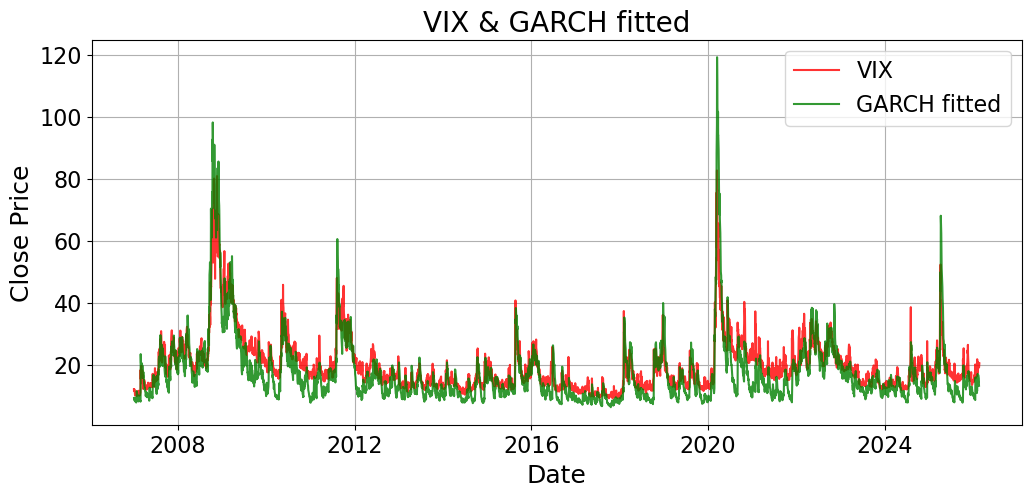

In [26]:
plt.figure(figsize=(12,5))
plt.plot(VIX_trim_Close, color='red', alpha = 0.8, label='VIX')
plt.plot(vol*(252**0.5), color='green', alpha = 0.8, label='GARCH fitted')
plt.grid()
plt.title('VIX & GARCH fitted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [27]:
# ======= GARCH(1,1) ======= #

In [28]:
start = dt.datetime(2007,1,1)
end = dt.datetime(2026,2,13)
returns = dlnSPX.dropna()
am = arch_model(100 * returns, vol='Garch', p=1, o=0, q=1, dist='Normal')

In [29]:
###INSERISCI LA SPLIT DATE CORRETTA##################################################

split_date = dt.datetime(2021,5,7)
res = am.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46383.79040538876
Iteration:      2,   Func. Count:     17,   Neg. LLF: 21639.837903010754
Iteration:      3,   Func. Count:     26,   Neg. LLF: 935309718.9282281
Iteration:      4,   Func. Count:     32,   Neg. LLF: 9615.79975782671
Iteration:      5,   Func. Count:     39,   Neg. LLF: 5102.0375968178505
Iteration:      6,   Func. Count:     45,   Neg. LLF: 7914.85921093356
Iteration:      7,   Func. Count:     52,   Neg. LLF: 4941.650391689018
Iteration:      8,   Func. Count:     58,   Neg. LLF: 4940.789390882766
Iteration:      9,   Func. Count:     63,   Neg. LLF: 4940.788589976442
Iteration:     10,   Func. Count:     68,   Neg. LLF: 4940.788552935584
Iteration:     11,   Func. Count:     73,   Neg. LLF: 4940.788552084008
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4940.788552084008
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 11

In [30]:
forecasts = res.forecast(horizon=1, start=split_date)

In [31]:
returns

,Close
Date,
2007-01-04 00:00:00-05:00,0.00
2007-01-05 00:00:00-05:00,-0.01
2007-01-08 00:00:00-05:00,0.00
2007-01-09 00:00:00-05:00,-0.00
2007-01-10 00:00:00-05:00,0.00
...,...
2026-02-13 00:00:00-05:00,0.00
2026-02-17 00:00:00-05:00,0.00
2026-02-18 00:00:00-05:00,0.01


In [32]:
ts_slice = hv_xday.loc["2021-05-07":"2026"]

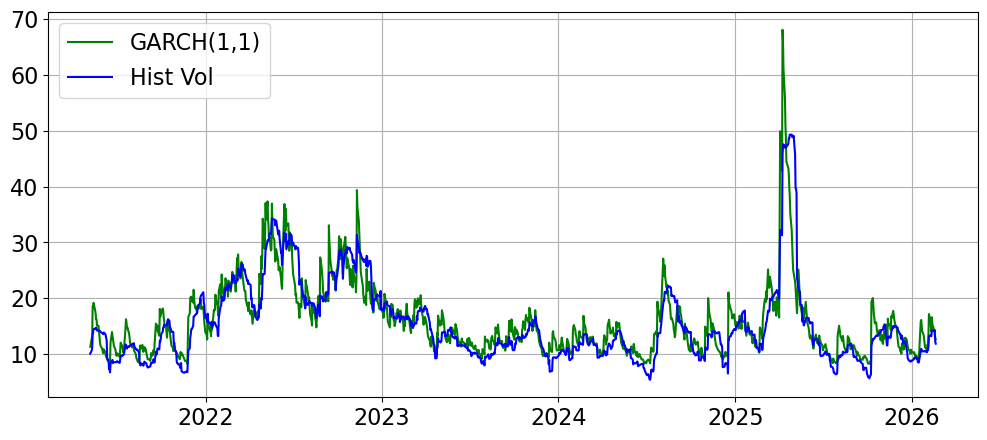

In [33]:
plt.figure(figsize=(12,5))
plt.plot(forecasts.variance**0.5*(252**0.5), color = 'green', label='GARCH(1,1)')
ts_slice = hv_xday.loc["2021-05-07":"2026"]
plt.plot(ts_slice.index, ts_slice.values, color = 'blue', label='Hist Vol')
plt.legend()
plt.grid()
plt.show()

In [34]:
df_compare = pd.concat([forecasts.variance**0.5*(252**0.5), ts_slice], axis=1)
df_compare.columns = ["GARCH", "HV"]
df_compare = df_compare.dropna()

rmse = np.sqrt(mean_squared_error(df_compare["HV"], df_compare["GARCH"]))

print("RMSE:", rmse)

RMSE: 3.49277007540817


In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Creiamo dataframe allineato
df_compare = pd.concat([forecasts.variance**0.5*(252**0.5), ts_slice], axis=1)
df_compare.columns = ["GARCH", "HV"]
df_compare = df_compare.dropna()

# RMSE
rmse = np.sqrt(mean_squared_error(df_compare["HV"], df_compare["GARCH"]))

# R^2
r2 = r2_score(df_compare["HV"], df_compare["GARCH"])

print("RMSE:", rmse)
print("R^2:", r2)


RMSE: 3.49277007540817
R^2: 0.7729779202990607


In [36]:
###DOES RANDOM FOREST MAKE BETTER JOB THAN A GARCH(1,1)?###

In [37]:
### Questa parte è uguale per tutti e due i Random Forest ###
# ======= Parametri =======
n_lags = 21 #quanto guarda indietro, lag dei rendimenti passati
forecast_horizon = 1 #la predizione è fatta in t + for_hor
window_vol = 21  #quanto lunga la predizione da t+ for_hor a t + for_hor + window vol

# ======= Creazione del dataset =======
returns = dlnSPX.dropna()
#vixret = dlnVIX.dropna()

df = pd.DataFrame()
df['r'] = returns
df['r**2'] = df['r']**2
#df['rvix'] = vixret

#creazione dei lag
for lag in range(1, n_lags+1):
    df[f'r_lag{lag}'] = df['r'].shift(lag)

for lag in range(1, n_lags+1):
    df[f'r**2_lag{lag}'] = df['r**2'].shift(lag)

#for lag in range(1, n_lags+1):
    #df[f'rvix_lag{lag}'] = df['rvix'].shift(lag)

##selezione target
df['target'] = 100 * df['r'].shift(-forecast_horizon).rolling(window=window_vol).std()*(252**0.5)
df = df.dropna()

df.head()

,r,r**2,r_lag1,r_lag2,r_lag3,r_lag4,r_lag5,r_lag6,r_lag7,r_lag8,...,r**2_lag13,r**2_lag14,r**2_lag15,r**2_lag16,r**2_lag17,r**2_lag18,r**2_lag19,r**2_lag20,r**2_lag21,target
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-05 00:00:00-05:00,-0.00,0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,-0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.18
2007-02-06 00:00:00-05:00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.17
2007-02-07 00:00:00-05:00,0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.20
2007-02-08 00:00:00-05:00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.74
2007-02-09 00:00:00-05:00,-0.01,0.00,-0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.59


In [38]:
df.head(3590)

,r,r**2,r_lag1,r_lag2,r_lag3,r_lag4,r_lag5,r_lag6,r_lag7,r_lag8,...,r**2_lag13,r**2_lag14,r**2_lag15,r**2_lag16,r**2_lag17,r**2_lag18,r**2_lag19,r**2_lag20,r**2_lag21,target
Date,,,,,,,,,,,,,,,,,,,,,
2007-02-05 00:00:00-05:00,-0.00,0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,-0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.18
2007-02-06 00:00:00-05:00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.17
2007-02-07 00:00:00-05:00,0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.20
2007-02-08 00:00:00-05:00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.74
2007-02-09 00:00:00-05:00,-0.01,0.00,-0.00,0.00,0.00,-0.00,0.00,0.01,0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03 00:00:00-04:00,0.00,0.00,-0.01,0.01,-0.00,-0.00,0.00,0.01,-0.01,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.65
2021-05-04 00:00:00-04:00,-0.01,0.00,0.00,-0.01,0.01,-0.00,-0.00,0.00,0.01,-0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.63
2021-05-05 00:00:00-04:00,0.00,0.00,-0.01,0.00,-0.01,0.01,-0.00,-0.00,0.00,0.01,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.93


In [39]:
df['r'].shift(2),df['r']

(Date
 2007-02-05 00:00:00-05:00     NaN
 2007-02-06 00:00:00-05:00     NaN
 2007-02-07 00:00:00-05:00   -0.00
 2007-02-08 00:00:00-05:00    0.00
 2007-02-09 00:00:00-05:00    0.00
                              ... 
 2026-02-12 00:00:00-05:00   -0.00
 2026-02-13 00:00:00-05:00   -0.00
 2026-02-17 00:00:00-05:00   -0.02
 2026-02-18 00:00:00-05:00    0.00
 2026-02-19 00:00:00-05:00    0.00
 Name: r, Length: 4791, dtype: float64,
 Date
 2007-02-05 00:00:00-05:00   -0.00
 2007-02-06 00:00:00-05:00    0.00
 2007-02-07 00:00:00-05:00    0.00
 2007-02-08 00:00:00-05:00   -0.00
 2007-02-09 00:00:00-05:00   -0.01
                              ... 
 2026-02-12 00:00:00-05:00   -0.02
 2026-02-13 00:00:00-05:00    0.00
 2026-02-17 00:00:00-05:00    0.00
 2026-02-18 00:00:00-05:00    0.01
 2026-02-19 00:00:00-05:00   -0.00
 Name: r, Length: 4791, dtype: float64)

In [40]:
df['r'].rolling(window=21).std()

Date
2007-02-05 00:00:00-05:00    NaN
2007-02-06 00:00:00-05:00    NaN
2007-02-07 00:00:00-05:00    NaN
2007-02-08 00:00:00-05:00    NaN
2007-02-09 00:00:00-05:00    NaN
                            ... 
2026-02-12 00:00:00-05:00   0.01
2026-02-13 00:00:00-05:00   0.01
2026-02-17 00:00:00-05:00   0.01
2026-02-18 00:00:00-05:00   0.01
2026-02-19 00:00:00-05:00   0.01
Name: r, Length: 4791, dtype: float64

In [41]:
df['r'].tail(21).std()

0.007748419714749086

In [42]:
dlnSPX.dropna().head(22)

,Close
Date,
2007-01-04 00:00:00-05:00,0.00
2007-01-05 00:00:00-05:00,-0.01
2007-01-08 00:00:00-05:00,0.00
2007-01-09 00:00:00-05:00,-0.00
2007-01-10 00:00:00-05:00,0.00
2007-01-11 00:00:00-05:00,0.01
2007-01-12 00:00:00-05:00,0.00
2007-01-16 00:00:00-05:00,0.00
2007-01-17 00:00:00-05:00,-0.00


In [43]:
# ======= Definizione X e Y =======
X = df.drop(columns=['target']) #[[f'r_lag{lag}' for lag in range(1, n_lags+1)]] #input

y = df['target'] #output

In [44]:
# ======= Split train/validation/test =======
n = len(df)

train_end = int(0.5 * n)
val_end   = int(0.75 * n)

train_index = range(0, train_end)
val_index   = range(train_end, val_end)
test_index  = range(val_end, n)

X_train = X.iloc[train_index]
y_train = y.iloc[train_index]

X_val = X.iloc[val_index]
y_val = y.iloc[val_index]

X_test = X.iloc[test_index]
y_test = y.iloc[test_index]

In [45]:
test_index

range(3593, 4791)

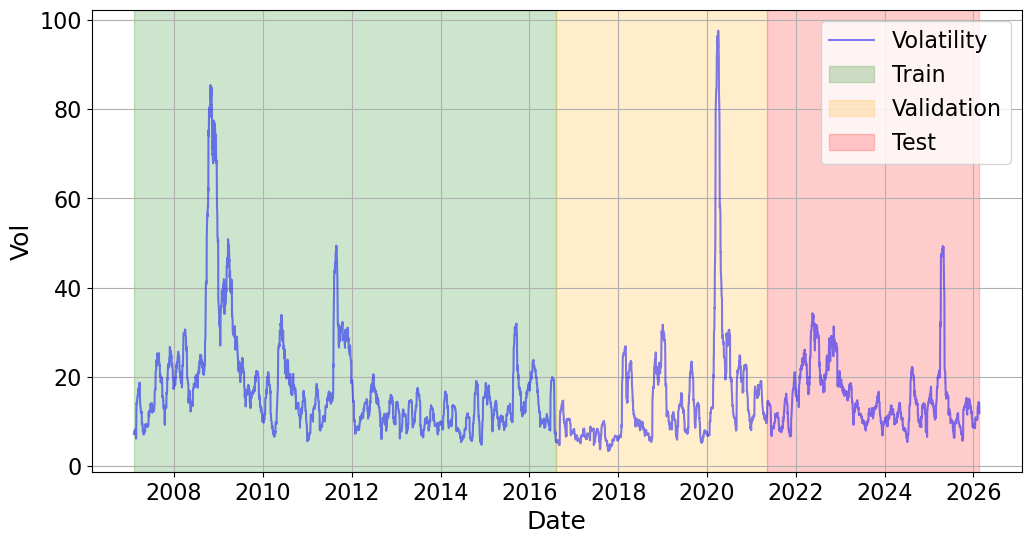

In [46]:
plt.figure(figsize=(12,6))
plt.plot(y.index, y, color='blue', alpha=0.5, label='Volatility')
plt.axvspan(y_train.index[0], y_train.index[-1], color='green', alpha=0.2, label='Train')
plt.axvspan(y_val.index[0], y_val.index[-1], color='orange', alpha=0.2, label='Validation')
plt.axvspan(y_test.index[0], y_test.index[-1], color='red', alpha=0.2, label='Test')
plt.xlabel('Date')
plt.ylabel('Vol')
plt.legend()
plt.grid()

plt.show()

In [ ]:
reg = LazyRegressor(verbose=1, ignore_warnings=True, random_state=42) #custom_metric=None)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

print(models)

In [48]:
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

In [49]:
##RANDOM FOREST##

In [50]:
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1)
rf.fit(X_train_full, y_train_full)

y_pred_rf = rf.predict(X_test)

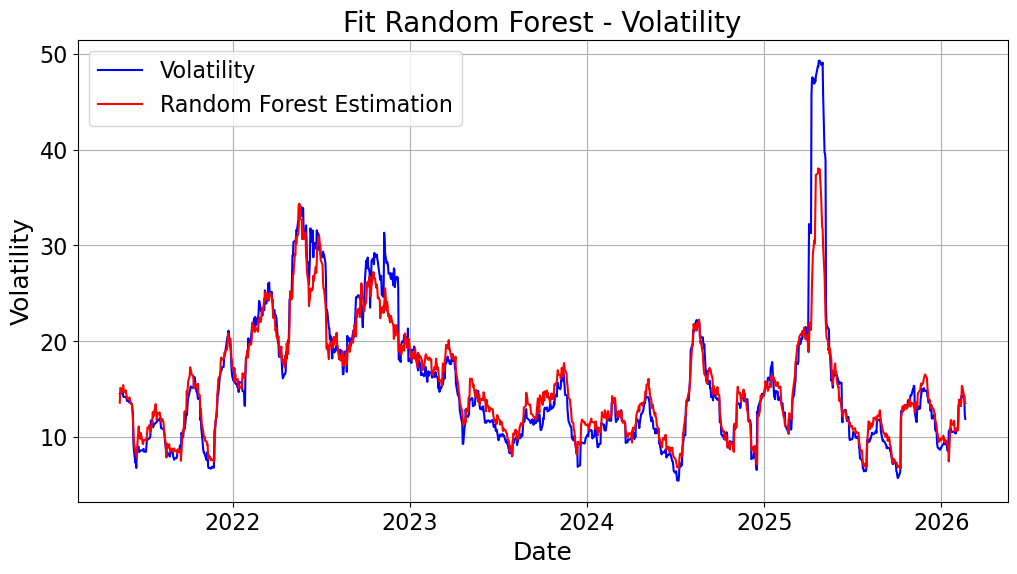

In [51]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_rf, label='Random Forest Estimation', color='red')
plt.title('Fit Random Forest - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [52]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 2.602330


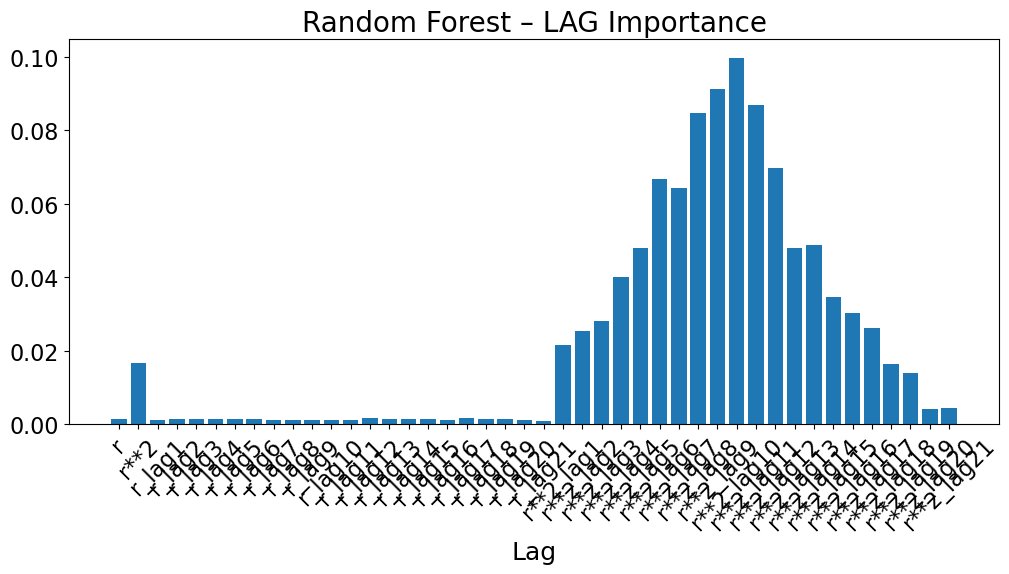

In [53]:
feature_names = X.columns

importances = rf.feature_importances_

plt.figure(figsize=(12,5))
plt.bar(feature_names, importances)
plt.xticks(rotation=45)
plt.title('Random Forest – LAG Importance')
plt.xlabel('Lag')

plt.show()

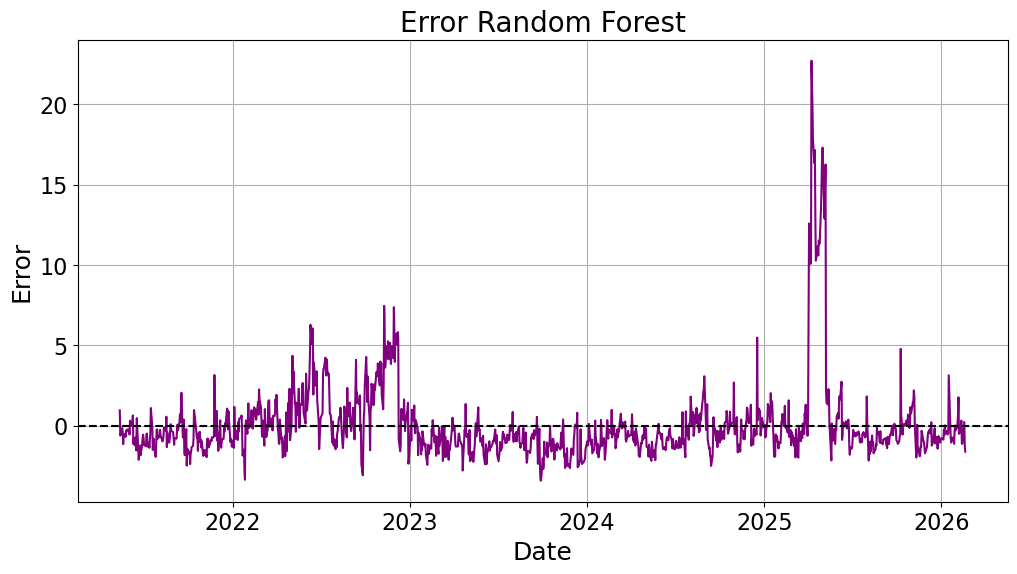

In [54]:
error = y_test - y_pred_rf

plt.figure(figsize=(12,6))
plt.plot(error.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error Random Forest')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

In [55]:
##GRADIENT BOOSTING REGRESSOR

In [56]:
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, min_samples_leaf=5, random_state=42)
gbr.fit(X_train_full, y_train_full)

y_pred_gbr = gbr.predict(X_test)

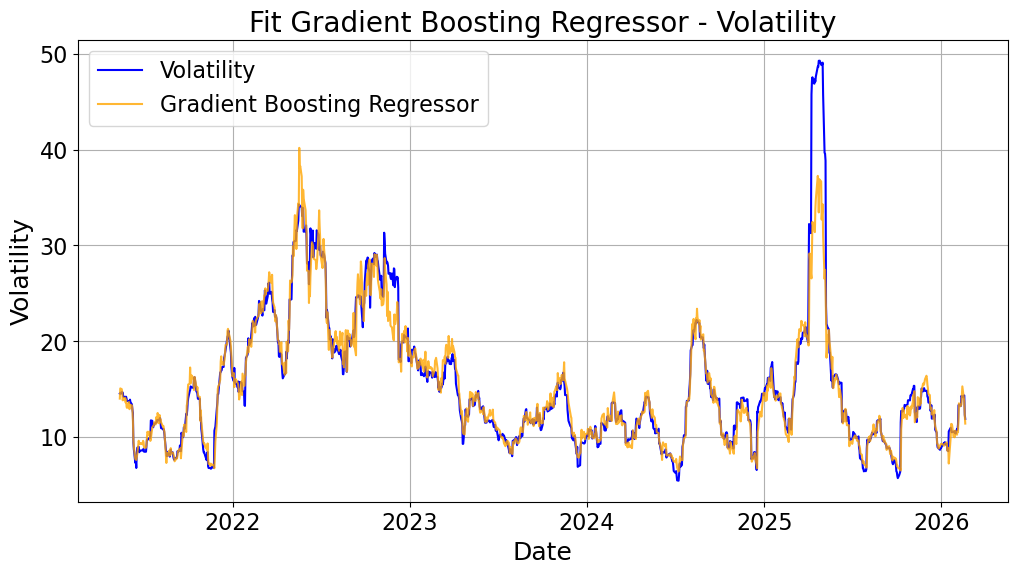

In [57]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_gbr, label='Gradient Boosting Regressor', color='orange', alpha =0.8)
plt.title('Fit Gradient Boosting Regressor - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 2.282931


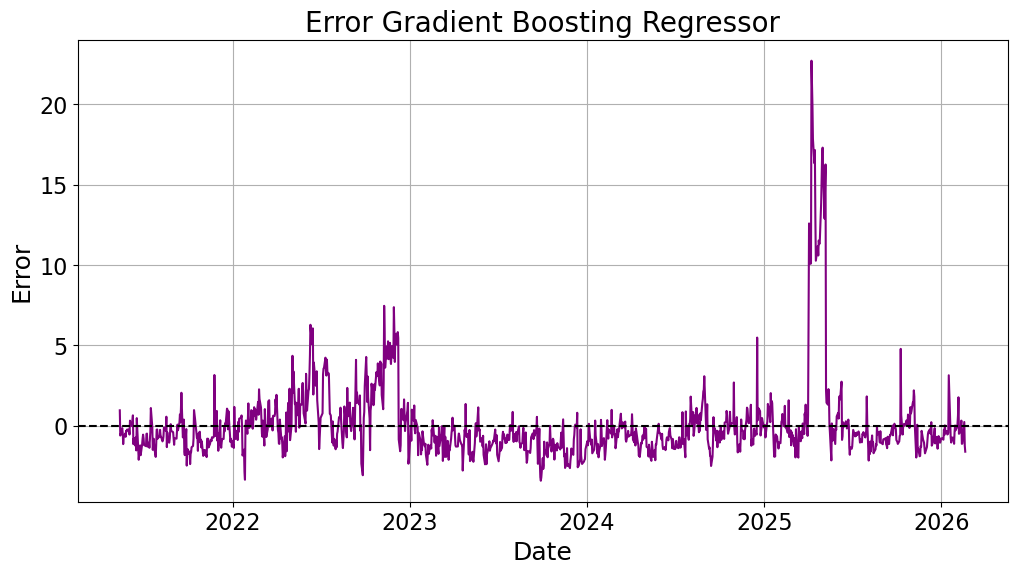

In [59]:
error_2 = y_test - y_pred_gbr

plt.figure(figsize=(12,6))
plt.plot(error_2.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error Gradient Boosting Regressor')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

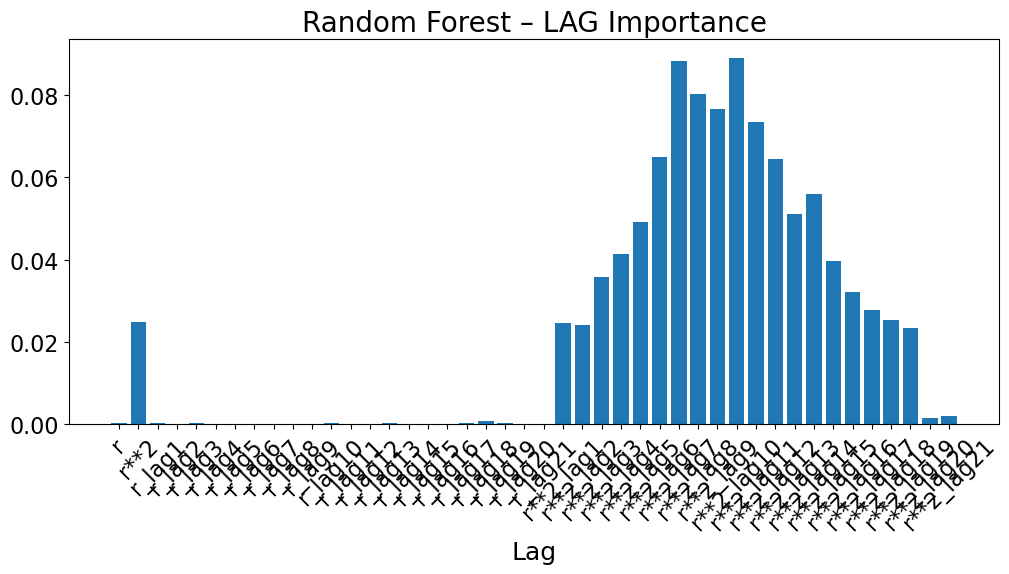

In [60]:
feature_names = X.columns

importances = gbr.feature_importances_

plt.figure(figsize=(12,5))
plt.bar(feature_names, importances)
plt.xticks(rotation=45)
plt.title('Random Forest – LAG Importance')
plt.xlabel('Lag')

plt.show()

In [61]:
##LGBM REGRESSOR

In [62]:
lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=31, min_data_in_leaf=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgbm.fit(X_train_full, y_train_full)

y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11220
[LightGBM] [Info] Number of data points in the train set: 3593, number of used features: 44
[LightGBM] [Info] Start training from score 16.755154
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


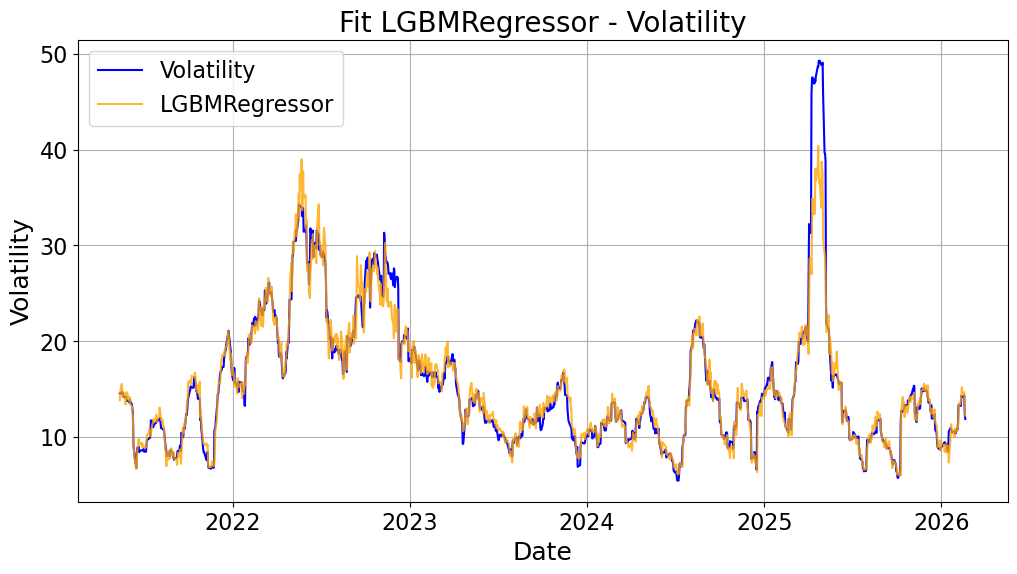

In [63]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_lgbm, label='LGBMRegressor', color='orange', alpha =0.8)
plt.title('Fit LGBMRegressor - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [64]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 2.044966


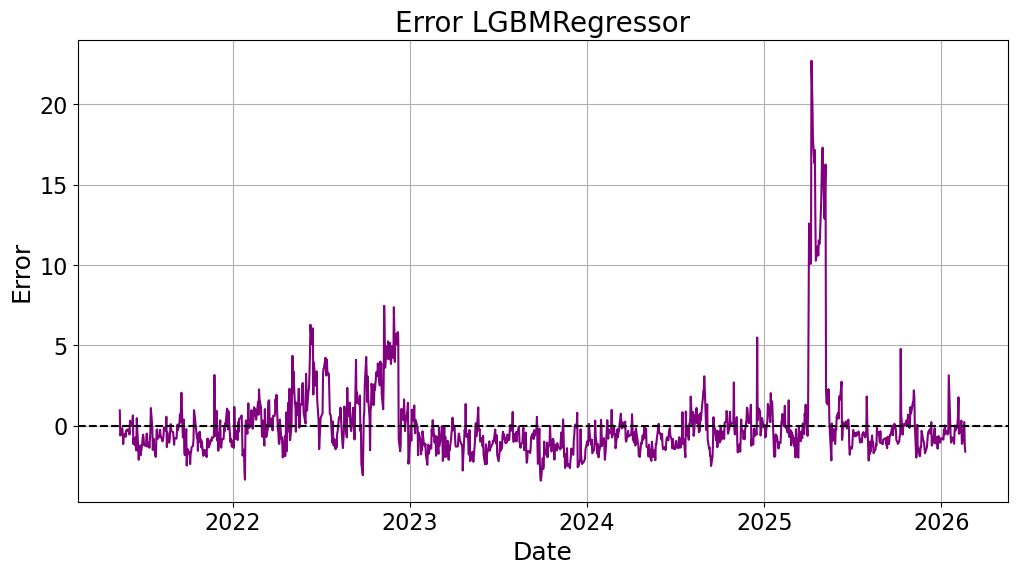

In [65]:
error_3 = y_test - y_pred_lgbm

plt.figure(figsize=(12,6))
plt.plot(error_2.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error LGBMRegressor')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

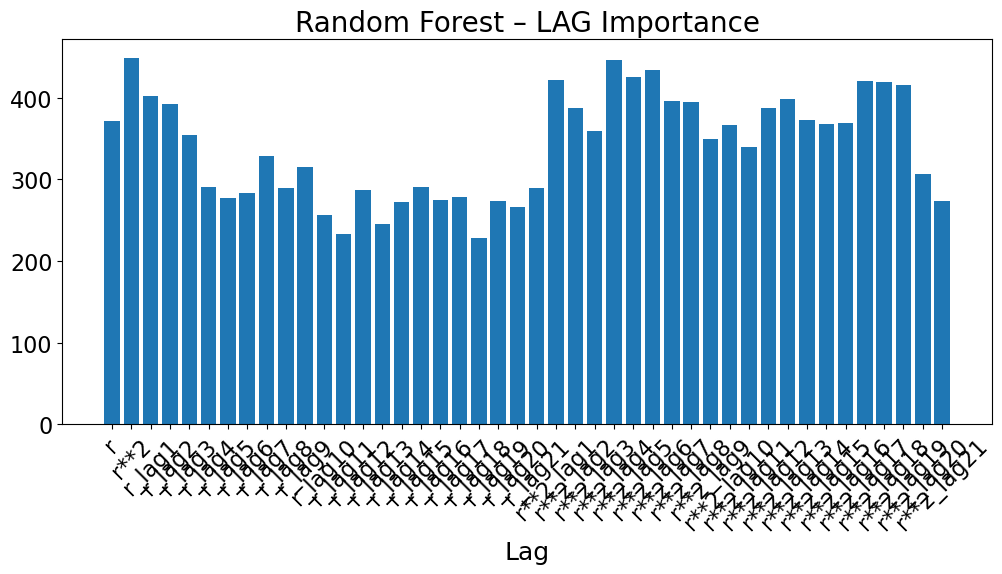

In [66]:
feature_names = X.columns

importances = lgbm.feature_importances_

plt.figure(figsize=(12,5))
plt.bar(feature_names, importances)
plt.xticks(rotation=45)
plt.title('Random Forest – LAG Importance')
plt.xlabel('Lag')

plt.show()

In [67]:
#HISTORIC GRADIENT BOOSTING REGRESSOR

In [68]:
hgbr = HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, max_depth=3, min_samples_leaf=5, random_state=42)
hgbr.fit(X_train_full, y_train_full)

y_pred_hgbr = hgbr.predict(X_test)

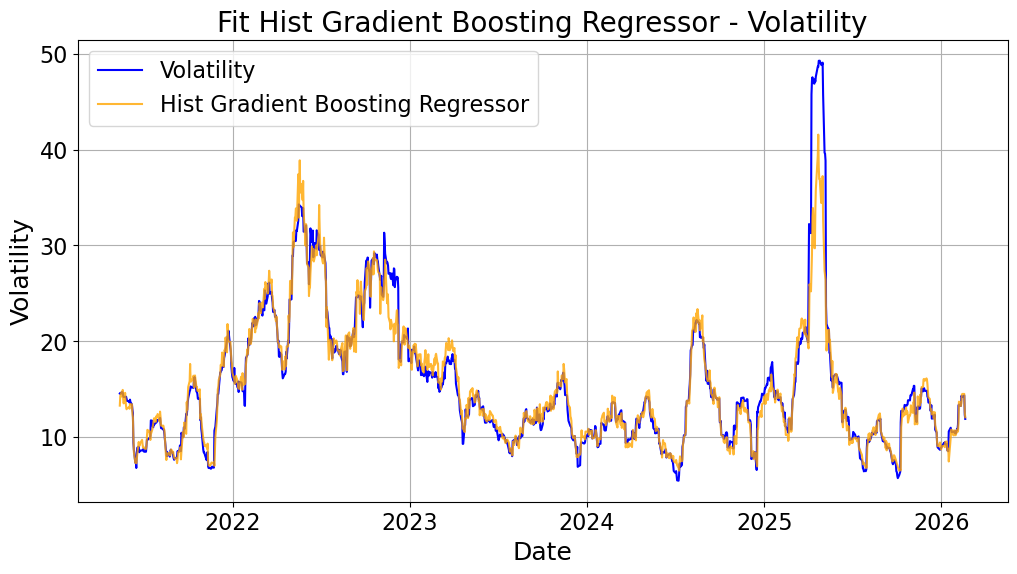

In [69]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_hgbr, label='Hist Gradient Boosting Regressor', color='orange', alpha =0.8)
plt.title('Fit Hist Gradient Boosting Regressor - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [70]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hgbr))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 2.201683


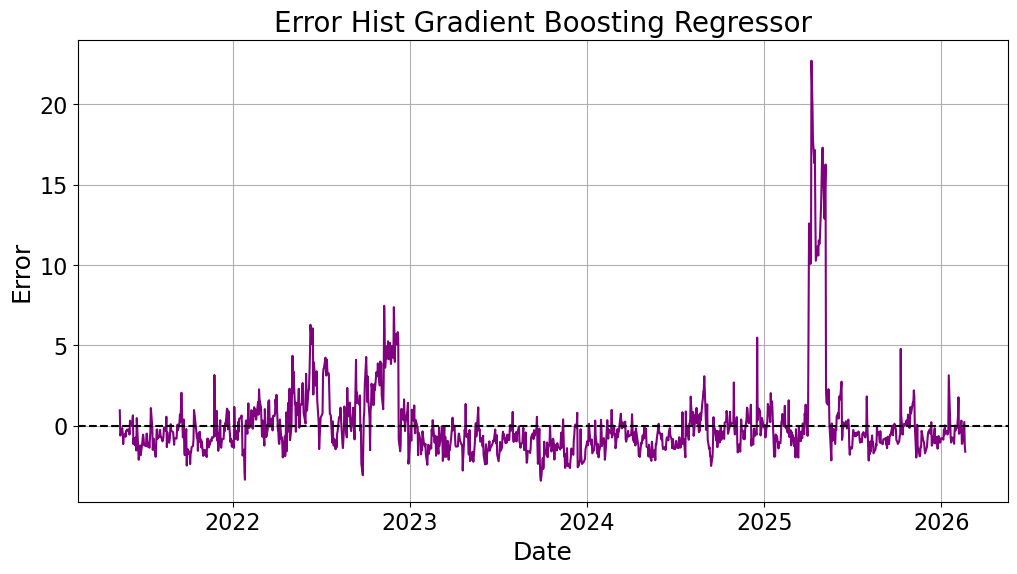

In [71]:
error_4 = y_test - y_pred_hgbr

plt.figure(figsize=(12,6))
plt.plot(error_2.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error Hist Gradient Boosting Regressor')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

In [72]:
#XGBREGRESSOR

In [73]:
xgbr = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, min_child_weight=5, subsample=0.8, colsample_bytree=0.8, objective="reg:squarederror", random_state=42, n_jobs=-1)
xgbr.fit(X_train_full, y_train_full)

y_pred_xgbr = xgbr.predict(X_test)

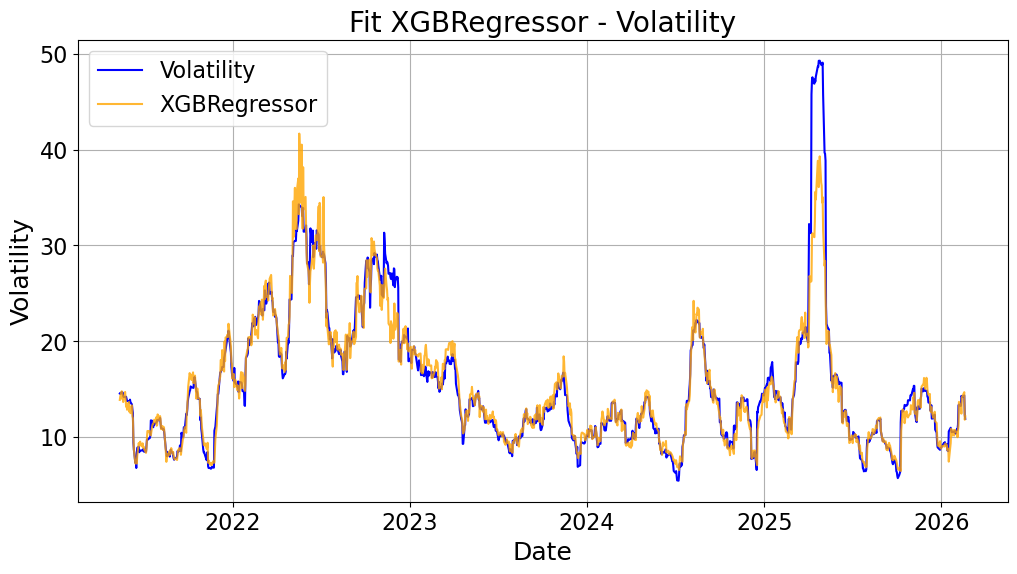

In [74]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_xgbr, label='XGBRegressor', color='orange', alpha =0.8)
#plt.plot(vol.tail(1150)/100, color='green', alpha = 0.8, label='GARCH fitted')
plt.title('Fit XGBRegressor - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [75]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgbr))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 2.254216


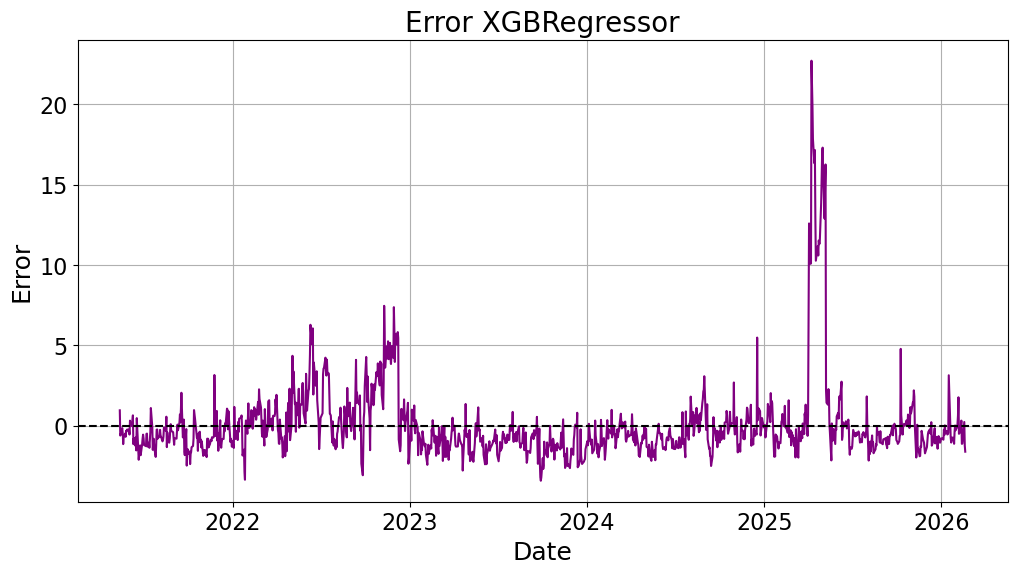

In [76]:
error_5 = y_test - y_pred_xgbr

plt.figure(figsize=(12,6))
plt.plot(error_2.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error XGBRegressor')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

In [77]:
#ExtraTreesRegressor

In [78]:
extraTreeReg = ExtraTreesRegressor(n_estimators=500, max_depth=10, min_samples_leaf=5, max_features="sqrt", bootstrap=False, random_state=42, n_jobs=-1)
extraTreeReg.fit(X_train_full, y_train_full)

y_pred_extraTreeReg = extraTreeReg.predict(X_test)

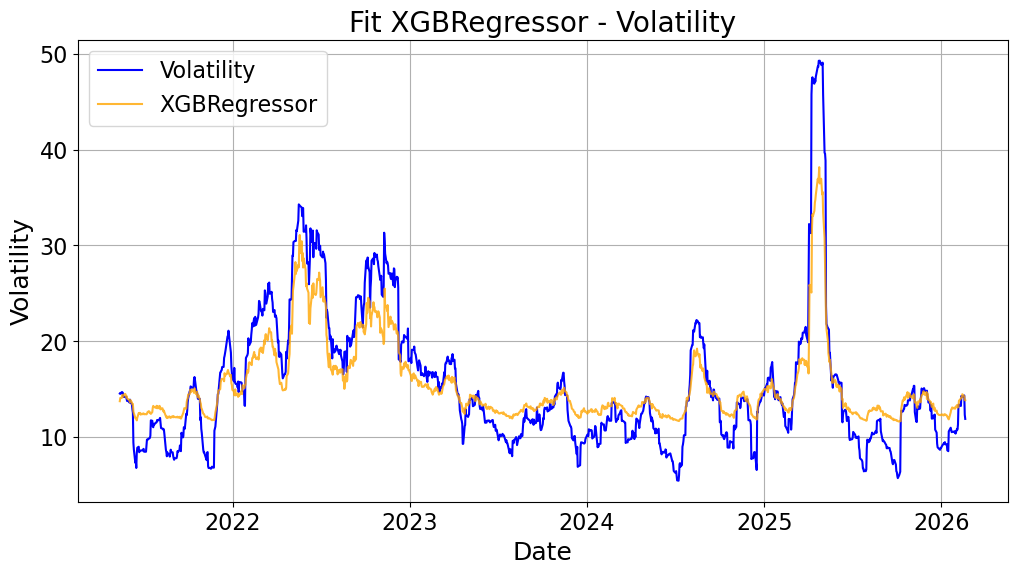

In [79]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Volatility', color='blue')
plt.plot(y_test.index, y_pred_extraTreeReg, label='XGBRegressor', color='orange', alpha =0.8)
#plt.plot(vol.tail(1150)/100, color='green', alpha = 0.8, label='GARCH fitted')
plt.title('Fit XGBRegressor - Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()

plt.show()

In [80]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_extraTreeReg))
print(f'RMSE ultimo split: {rmse:.6f}')

RMSE ultimo split: 3.289913


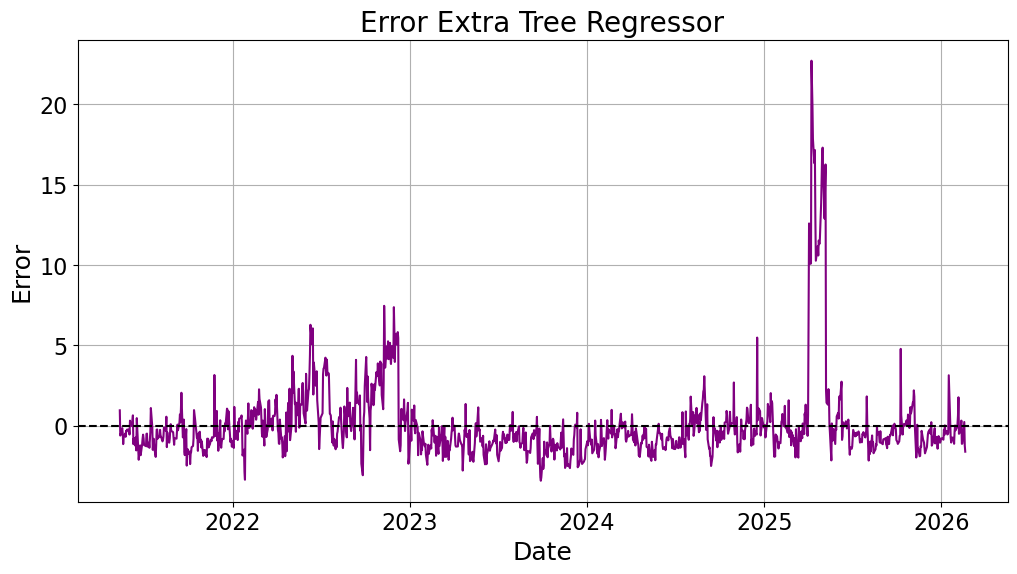

In [81]:
error_6 = y_test - y_pred_extraTreeReg

plt.figure(figsize=(12,6))
plt.plot(error_2.index, error, color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Error Extra Tree Regressor')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid()

plt.show()

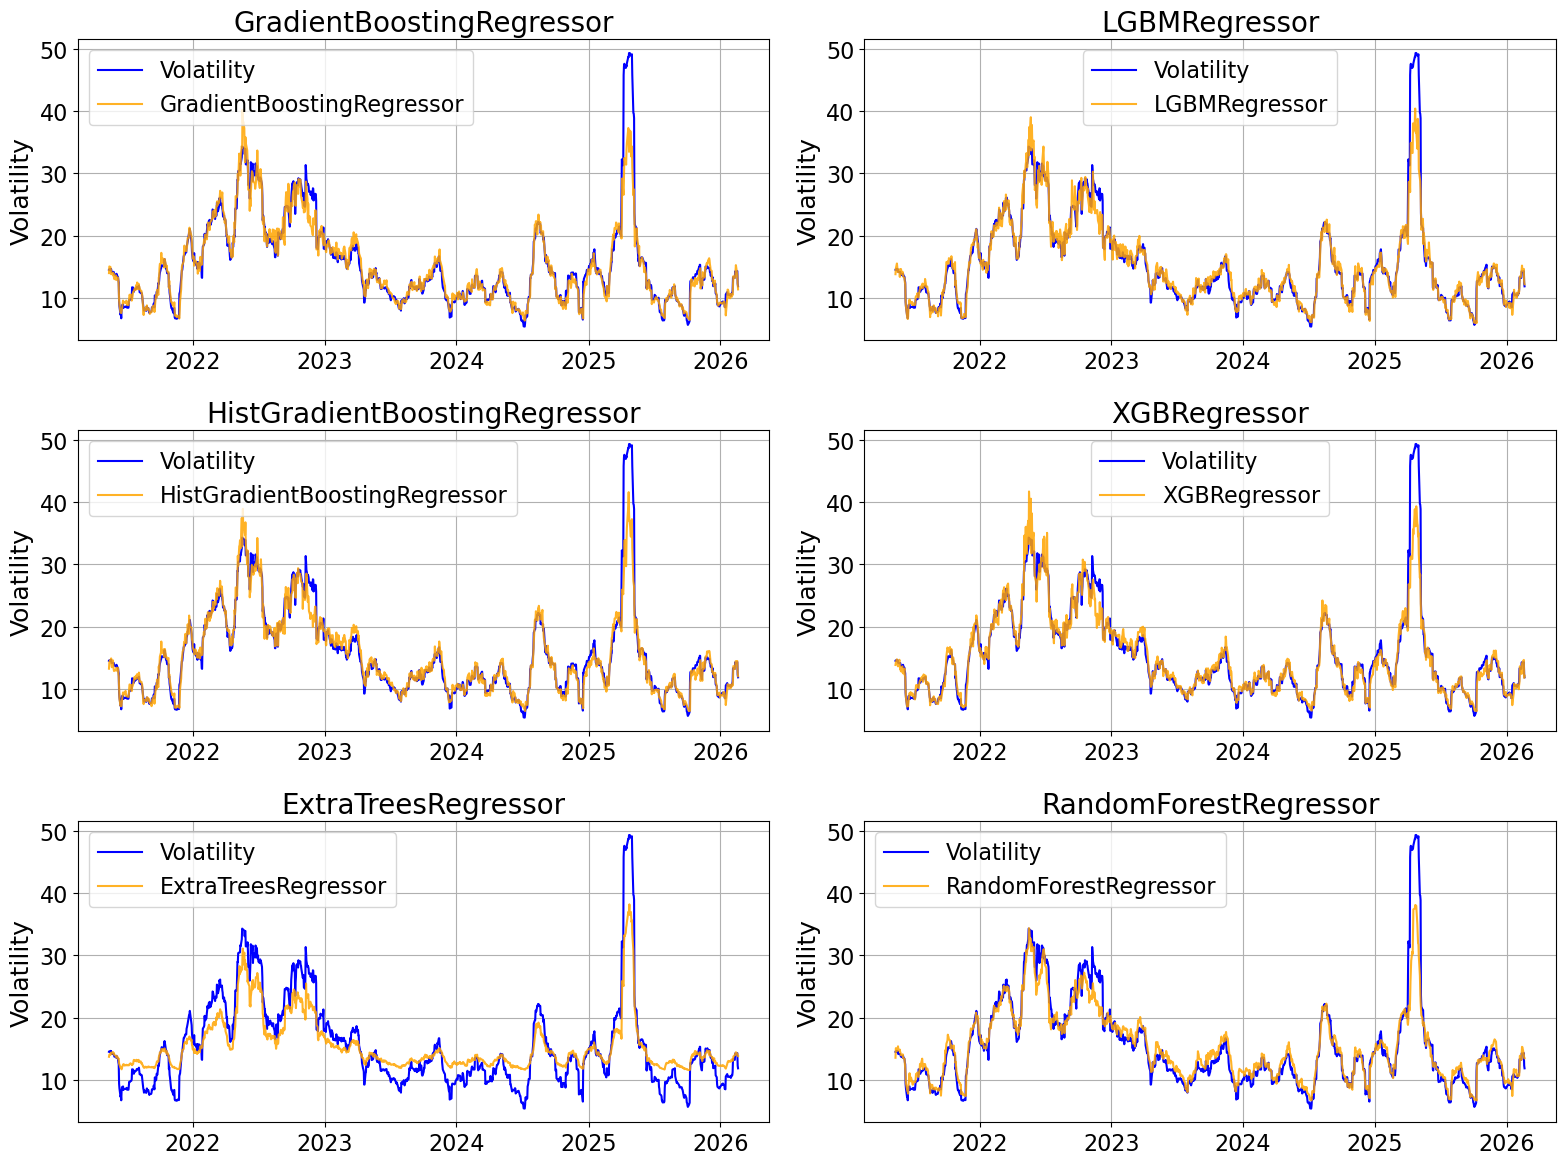

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Assicuriamoci che l'indice sia datetime
y_test.index = pd.to_datetime(y_test.index)

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)

models = [
    ("GradientBoostingRegressor", y_pred_gbr),
    ("LGBMRegressor", y_pred_lgbm),
    ("HistGradientBoostingRegressor", y_pred_hgbr),
    ("XGBRegressor", y_pred_xgbr),
    ("ExtraTreesRegressor", y_pred_extraTreeReg),
    ("RandomForestRegressor", y_pred_rf)
]

axes = axes.flatten()

for ax, (name, prediction) in zip(axes, models):
    ax.plot(y_test.index, y_test, label='Volatility', color='blue')
    ax.plot(y_test.index, prediction, label=name, color='orange', alpha=0.85)

    ax.set_title(f'{name}')
    ax.set_ylabel('Volatility')
    ax.grid()
    ax.legend()

    # Formattazione anni
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Forza la visualizzazione delle label su tutti i subplot
    ax.tick_params(axis='x', labelbottom=True)

plt.tight_layout()
plt.show()


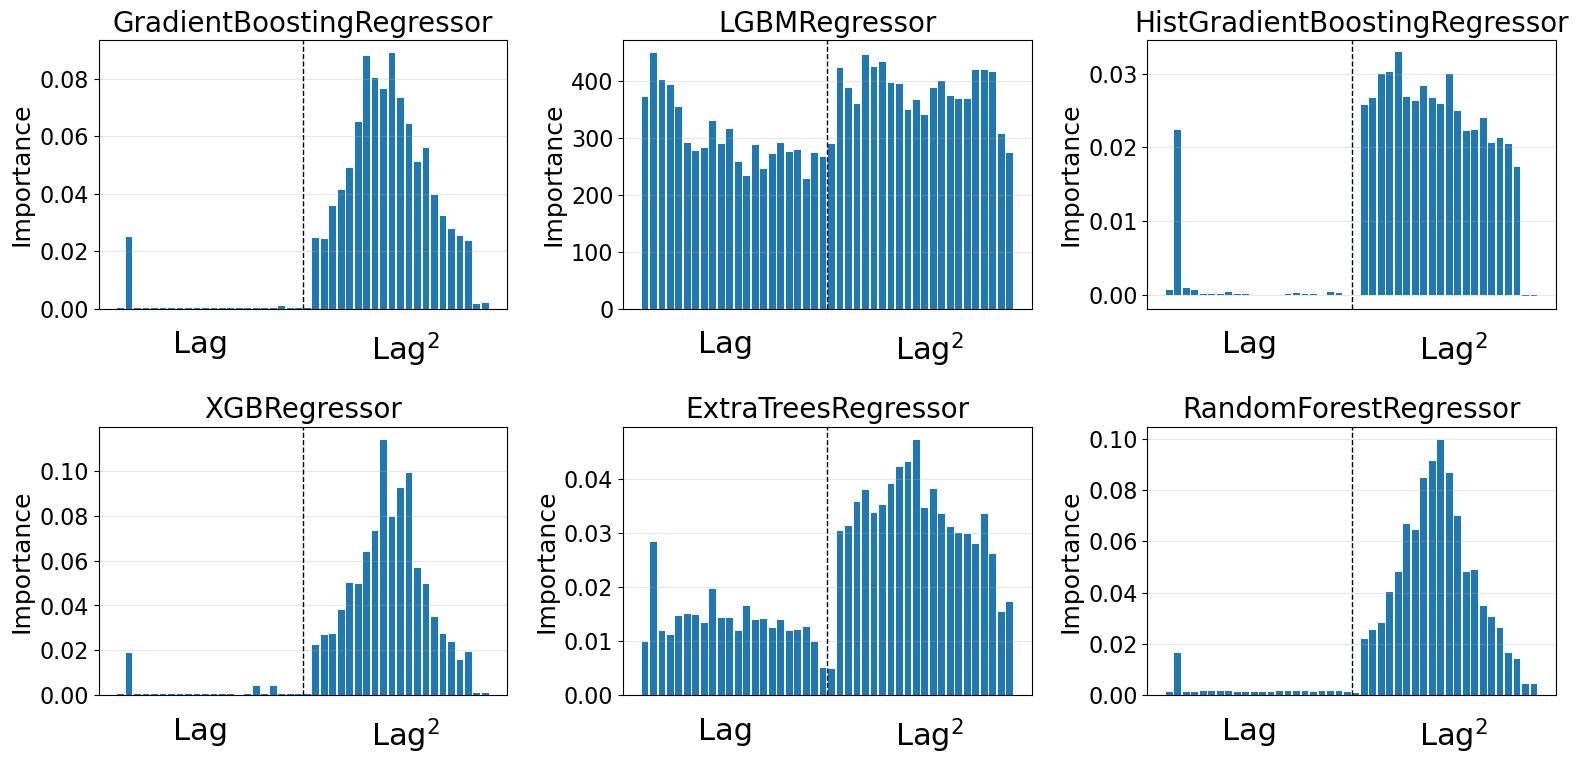

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

feature_names = np.array(X.columns)
n_features = len(feature_names)
split_index = n_features // 2   # punto di divisione Lag / Lag^2

models = [
    ("GradientBoostingRegressor", gbr),
    ("LGBMRegressor", lgbm),
    ("HistGradientBoostingRegressor", hgbr),
    ("XGBRegressor", xgbr),
    ("ExtraTreesRegressor", extraTreeReg),
    ("RandomForestRegressor", rf)
]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models):

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        result = permutation_importance(
            model,
            X_test,
            y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importances = result.importances_mean

    ax.bar(range(n_features), importances)

    # Linea verticale di separazione
    ax.axvline(split_index - 0.5, color='black', linestyle='--', linewidth=1)

    # Rimuoviamo le label singole
    ax.set_xticks([])

    # Scriviamo Lag e Lag² più grandi
    ax.text(0.25, -0.08, "Lag",
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=22,
            )

    ax.text(0.75, -0.08, r"Lag$^2$",
            transform=ax.transAxes,
            ha='center', va='top',
            fontsize=22,
            )

    ax.set_title(name)
    ax.set_ylabel("Importance")
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()




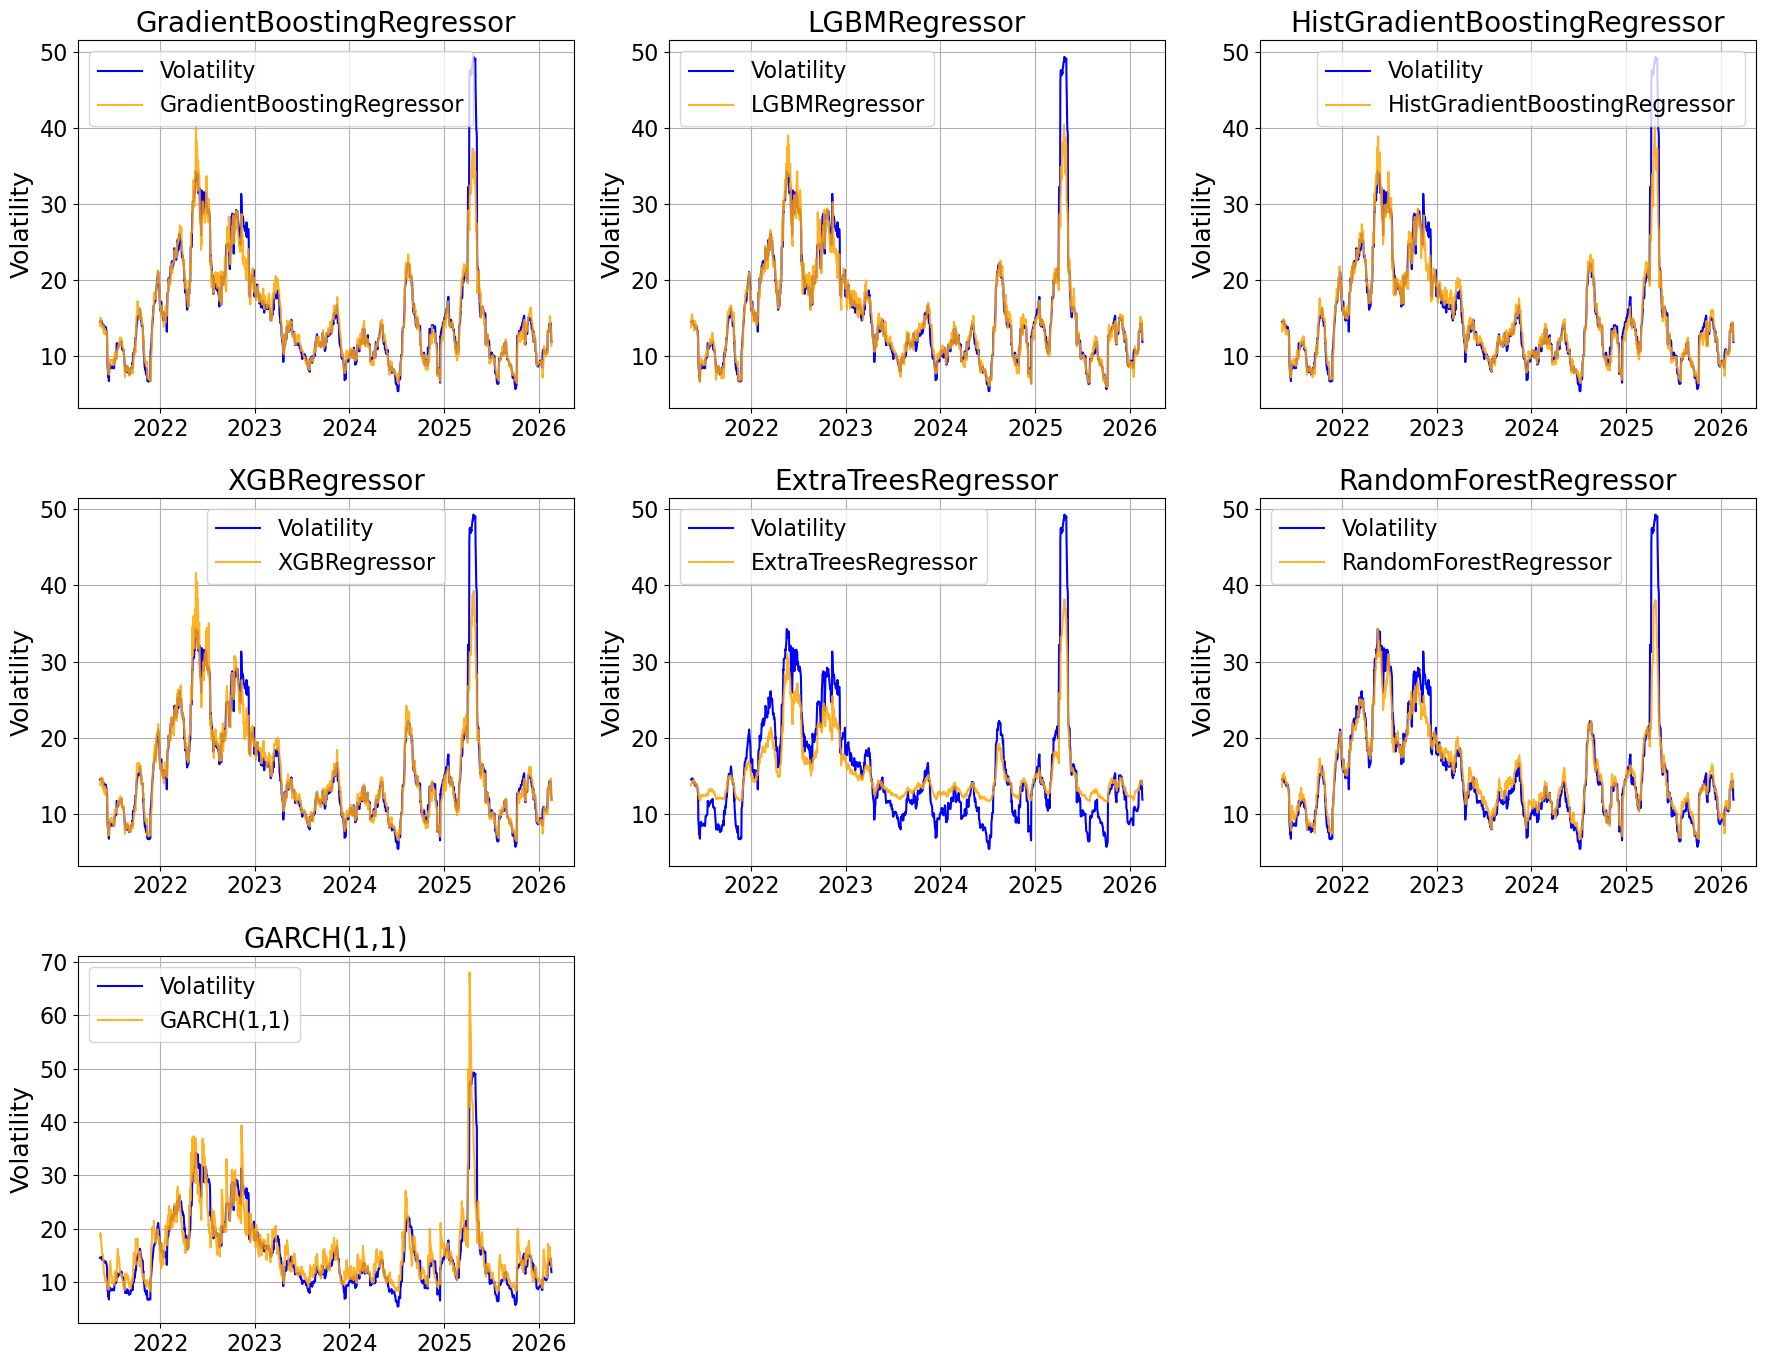

In [84]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Assicuriamoci che l'indice sia datetime
y_test.index = pd.to_datetime(y_test.index)

# === GARCH forecast annualizzato ===
garch_vol = forecasts.variance**0.5 * (252**0.5)
garch_vol.index = pd.to_datetime(garch_vol.index)

# Allineamento con y_test
garch_vol = garch_vol.loc[y_test.index]

fig, axes = plt.subplots(3, 3, figsize=(18, 14), sharex=True)
axes = axes.flatten()

models = [
    ("GradientBoostingRegressor", y_pred_gbr),
    ("LGBMRegressor", y_pred_lgbm),
    ("HistGradientBoostingRegressor", y_pred_hgbr),
    ("XGBRegressor", y_pred_xgbr),
    ("ExtraTreesRegressor", y_pred_extraTreeReg),
    ("RandomForestRegressor", y_pred_rf),
    ("GARCH(1,1)", garch_vol)
]

for i, (name, prediction) in enumerate(models):

    ax = axes[i]

    ax.plot(y_test.index, y_test, label='Volatility', color='blue')
    ax.plot(y_test.index, prediction, label=name, color='orange', alpha=0.85)

    ax.set_title(name)
    ax.set_ylabel('Volatility')
    ax.grid()
    ax.legend()

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', labelbottom=True)

# Spegniamo eventuali pannelli vuoti
for j in range(len(models), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


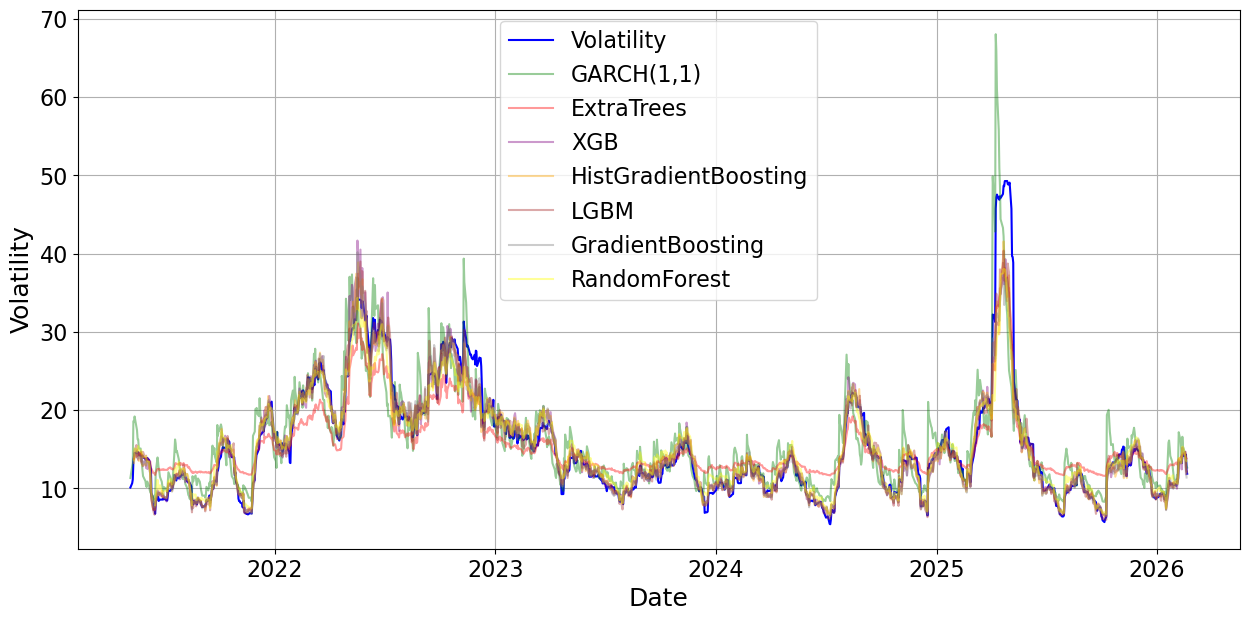

In [85]:
plt.figure(figsize=(15,7))
plt.plot(ts_slice.index, ts_slice.values, label='Volatility', alpha =1, color = 'blue')
plt.plot(forecasts.variance**0.5*(252**0.5), label='GARCH(1,1)', color = 'green', alpha =0.4)
plt.plot(y_test.index, y_pred_extraTreeReg, label='ExtraTrees', alpha =0.4, color = 'red')
plt.plot(y_test.index, y_pred_xgbr, label='XGB', alpha =0.4, color = 'purple')
plt.plot(y_test.index, y_pred_hgbr, label='HistGradientBoosting', alpha =0.4, color = 'orange')
plt.plot(y_test.index, y_pred_lgbm, label='LGBM', alpha =0.4, color = 'brown')
plt.plot(y_test.index, y_pred_gbr, label='GradientBoosting', alpha =0.4, color = 'grey')
plt.plot(y_test.index, y_pred_rf, label='RandomForest', alpha =0.4, color = 'yellow')
ts_slice = hv_xday.loc["2021-05-07":"2026"]
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()